<p> Run a simulation of filling in a network based on the 7 de Septiembre neighborhood layout in Araijan </p>
<p>**(.inp and .config files already written)**</p>
<p> Below you see how to:</p>
<ul>
<li>Set boundary and initial conditions </li>
<li>Run a simulation until time T= 1200 s</li>
<li>plot time series of pressure head at different points in a single pipe</li>
<li>plot time series of pressure head at sample points in various pipes</li>
<li>plot space dependence of pressure head at a certain time</li>
<li>look at velocities</li>
<li>plot network layout</li>
</ul>

In [1]:
from __future__ import division
import sys
sys.path.append("..")  
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

fi = "../indata/Xindata/Tjunction_Aboundary.inp"    
fc = "../indata/Xindata/Tjunction_Aboundary.config" 
mtype = 1                          
n1 = PyNetwork(fi,fc,mtype)

Populating the interactive namespace from numpy and matplotlib


In [2]:
##### Given a target pressure head H, set IC for a certain pipe i, using recursion to find #######
def SetPipeIC (n1, i, H, left, right):
    L = n1.Ls[i]
    N = n1.Ns[i]
    D = n1.Ds[i]
    dx = L/N
    diff = (right-left)/N
    pipe = PyPipe_ps(N,D,L,n1.M,n1.a[0])
    A = []
    A_crt = 1e-4
    Q_crt = 1e-10
    for k in xrange(N):
        current = left + (k+1/2)*diff
        deltaH = H - current            # DeltaH is pressure head we want
        if deltaH <= pipe.pbar(A_crt, False):
            A_current = A_crt
        else:
            A_current = Aofpbar(pipe, deltaH, i)     
        A.append(A_current)
        #print pipe.pbar(A_current, False) + current
    Q = Q_crt*np.ones(N)
    n1.setIC(i, A, Q)

########################## Set IC for all pipes #################################
pipe_ini = PyPipe_ps(n1.Ns[0],n1.Ds[0],n1.Ls[0],n1.M,n1.a[0])

# IC of the pipe (dry)
for pipe in xrange(0,4):
#     A_crt = n1.Ds[pipe]**2*np.pi/4.*1e-2
#     print pipe_ini.HofA(A_crt, True)
    L = n1.Ls[pipe]
    N = n1.Ns[pipe]
    D = n1.Ds[pipe]
    pipe_obj = PyPipe_ps(N,D,L,n1.M,n1.a[0])
    A_crt = pipe_obj.AofH(1e-4, False)
    print A_crt
#     A_crt = D**2.*np.pi/4.*1e-2
    Q_crt = 1e-3*A_crt
    Ni = n1.Ns[pipe]
    n1.setIC(pipe, A_crt*np.ones(Ni), Q_crt*np.ones(Ni))
print 'IC completed'


Hs = [
    0.,
    0.005213062,
    0.064729275,
    0.113543643,
    0.10987382,
    0.072484511,
    0.042774401,
    0.218112965,
    0.556493528,
    0.874808504,
    1.357798772,
    1.351942922,
    1.620129641,
    2.993705389,
    4.411844237,
    5.485497213,
    6.191676862,
    6.030217251,
    5.807294631,
    6.696944006,
    7.979879046,
    9.397738118,
    10.77505431,
    11.59015728,
    12.26105473,
    12.88992372,
    13.18348578,
    13.23164522,
    13.29032390,
    13.30687062,
    13.18583984,
    13.11104414,
    13.06934684,
]


6.66586660952e-07
6.66586660952e-07
1.32932616256e-07
3.86298670767e-07
IC completed


In [3]:
############### Set Parameters for loop ###########################
T_total = n1.T*30
###################################################################
M = n1.M
T = n1.T
# i = 0 means A, i=1 means Q
# j means the grid we are currently looking at, 1<=j<=N
# n means time step 
# N means the grid number in this certain pipe
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

# conn: np.ndarray
#       Nedgesx2 array of ints. Row i = [start node, end node] for pipe i.
pipe_number = len(n1.conn)
model_number = int(T_total/n1.T)
dt = n1.T/float(n1.M)

# Store all the pressure head data before T
P_beforeT = [] 
# Store all the pressure head data after T
P_afterT = []  
# Store the IC condition for each round of simulation
# ICs = { pipe: [ [A],[Q] ] }, therefore A = ICs[pipe][0], Q = ICs[pipe][1] 
ICs = {}


 
for k in xrange(model_number):
    A_in_start = pipe_ini.AofH(Hs[k], True) 
    A_in_end = pipe_ini.AofH(Hs[k+1], True)
    print "The current boundary is",Hs[k],"--",Hs[k+1]
    A_boun = np.linspace(A_in_start,A_in_end,n1.M+1)    
    n1.setbVal(0,A_boun)
    if k != 0:
        t1 = time.time()
        for pipe in xrange(pipe_number):
            n1.setIC(pipe, ICs[pipe][0], ICs[pipe][1])
        n1.runForwardProblem(dt)
        t2 = time.time()
    else:
        t1 = time.time()
        n1.runForwardProblem(dt)
        t2 = time.time()
    print 'Piece %d of %d, running time = %.1fs'%(k+1, model_number, t2-t1)
    for pipe in xrange(pipe_number):
        qh = n1.qhist(pipe)
        N = n1.Ns[pipe]
        A = [qh[idx_t(0, ja, M, N)] for ja in xrange(1,N+1)]
        Q = [qh[idx_t(1, jq, M, N)] for jq in xrange(1,N+1)]
        ICs.update({pipe: [A, Q]})
    n1.reset()
   
  


The current boundary is 0.0 -- 0.005213062
Piece 1 of 30, running time = 137.5s
The current boundary is 0.005213062 -- 0.064729275
Piece 2 of 30, running time = 141.6s
The current boundary is 0.064729275 -- 0.113543643
Piece 3 of 30, running time = 138.8s
The current boundary is 0.113543643 -- 0.10987382
Piece 4 of 30, running time = 141.5s
The current boundary is 0.10987382 -- 0.072484511
Piece 5 of 30, running time = 139.8s
The current boundary is 0.072484511 -- 0.042774401
Piece 6 of 30, running time = 142.2s
The current boundary is 0.042774401 -- 0.218112965
Piece 7 of 30, running time = 141.4s
The current boundary is 0.218112965 -- 0.556493528
Piece 8 of 30, running time = 140.0s
The current boundary is 0.556493528 -- 0.874808504
Piece 9 of 30, running time = 140.8s
The current boundary is 0.874808504 -- 1.357798772
Piece 10 of 30, running time = 138.2s
The current boundary is 1.357798772 -- 1.351942922
Piece 11 of 30, running time = 137.5s
The current boundary is 1.351942922 -- 1

In [4]:
# i = 0 means A, i=1 means Q
# j means the grid we are currently looking at, 1<=j<=N
# n means time step 
# N means the grid number in this certain pipe
# def idx_t(i,j,n,N):
#     return (2*(N+2)*n+(N+2)*i+j)

# import time
# V0 = n1.getTotalVolume()
# dt = n1.T/float(n1.M)
# dx = n1.Ls/[float(nn) for nn in n1.Ns]
# t0 = time.clock()
# n1.runForwardProblem(dt)
# tf = time.clock()
# Vf = n1.getTotalVolume()
# print "Solve time is %.5f s"%(tf-t0)
# print "Simulated time is %.5f s"%n1.T
# print "change in volume is %e m^3"%(Vf-V0)        

12.897338692766441


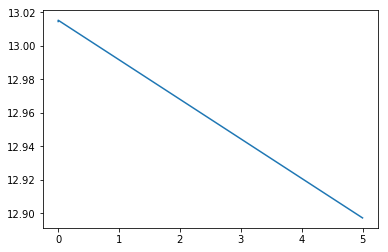

In [5]:
t = linspace(0,n1.T, n1.M+1)
P0 = n1.pressureTimeSeries(0,-1)#int(n1.Ns[0]/2)*2-1) 
plt.figure()
plt.plot(t,P0)
print P0[-1]

20 0.0005


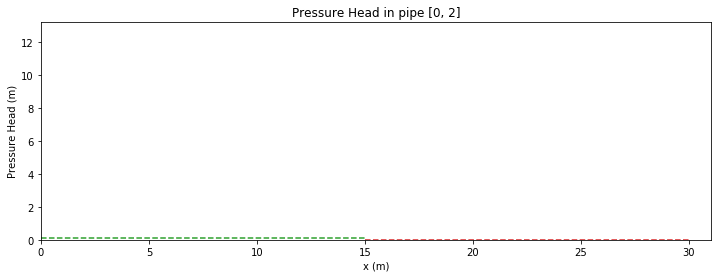

'Save Anna Result'

In [7]:
##### Continuous Animation, Fiexed Opening ########
M = n1.M  
T = n1.T
from matplotlib import animation
#*********************************************************************************
pipe_interest=[0,2]
t_delta=20*dt              # unit: s
t_start=0               # unit:s
t_end=n1.T               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)


#create initial figure
fig = plt.figure(figsize= (12,4))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(0,13.2)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest))

pipe_length = 0
## Record the sequence of outflow pipe
out = 0
for pipe in pipe_interest:
    # create x axis
    x = np.linspace(pipe_length,pipe_length+n1.Ls[pipe],n1.Ns[pipe])
    
    # create pipe full line
    p0 = PyPipe_ps(n1.Ns[pipe], n1.Ds[pipe],n1.Ls[pipe], M, n1.a[0])
    A0 = n1.Ds[pipe]*n1.Ds[pipe]/4*3.14
    H_full = [p0.Eta(A0,True)/9.81/A0]*len(x) 
    H_full = (np.add(H_full, 0.*len(H_full))).tolist()
    plt.plot(x, H_full,'--',label= 'pipe %d full'%(pipe))
    pipe_length += n1.Ls[pipe]
    
#legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)
# initialization function: plot the background of each frame


def init():
    for line in lines:
        line.set_data([], [])
    return lines

dt = n1.T/n1.M
Mi_draw=int(t_delta/dt)   # difne how many steps to skip
print Mi_draw, dt
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]


# H_interested_fixed = [ [H1], [H2],... [Hn] ], it stores all pipe's pressure info @ certain time
# H_interest = [ [PressureInfo @ time 1], [Pressure info @ time 2],..,[ Pressure Info @ time m]   ]
def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):  
        ## get pipe j
        j = pipe_interest[i]
        #this returns H as a function of x in pipe j at time step m
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw) 
        #Hx = myWaterDepthSpace(n1, j, M_start+index*Mi_draw)
        # Add elevation to the pressure head
        # nd.array can add list to get a new array like matrix sum
        """
        edge = n1.conn[j]
        left = elev[edge[0]]
        right = elev[edge[1]]
        diff = right - left
        Nj = n1.Ns[j]
        He = [left + diff/Nj*(i+0.5)  for i in xrange(Nj)]
        Hx = Hx + He
        """
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%.2fs'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=30, blit=False)
plt.show()
"""Save Anna Result"""
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/Two_end/single_both_end_inflow.mp4')

In [9]:

# Write .config file
with open("../indata/Xindata/Saket.config","w") as fw:
    pipeinfo = []      # [pipe, length]
    junctioninfo = {}  # junction: 1 node, 2 node or 3 node
    orificeinfo = {}   # junction: diameter
    with open("../indata/Xindata/Saket.inp","r") as fr:
        Bool = False
        for line in fr:
            line = line.split()
            if line and Bool and line[0] != ";ID":
#                 print line
                pipeinfo.append( [line[0], int(double(line[3]))])
                node1 = int(line[1])
                node2 = int(line[2])
                if node1 in junctioninfo:
                    junctioninfo[node1] += 1
                else:
                    junctioninfo.update({node1:1})
                if node2 in junctioninfo:
                    junctioninfo[node2] += 1
                else:
                    junctioninfo.update({node2:1})
                
                if node1 in orificeinfo:
                    orificeinfo[node1] = 0
                else:
                    orificeinfo.update({node1:double(line[4])})
                if node2 in orificeinfo:
                    orificeinfo[node2] = 0
                else:
                    orificeinfo.update({node2:double(line[4])})
                
            if line and line[0]== "[PIPES]":
                Bool = True
            if not line:
                Bool = False
    fw.write("[PIPE_INFO]\n")
    fw.write(";-------------------------------------------\n")
    fw.write(";             initial  initial\n")
    fw.write("; ID    N       h       Q\n")
    fw.write(";-------------------------------------------\n")
    for i in range(len(pipeinfo)):
        fw.write('%2s      %3d      0.1       0\n'%(pipeinfo[i][0], pipeinfo[i][1]))
    fw.write("\n \n \n \n")
    fw.write("[JUNCTION_INFO]\n")
    fw.write(";-------------------------------------------------------------------------------------\n")
    fw.write(";{-----for junction1s-----} | {--for junction2s--}             | {------for junction3s-------}|\n")
    fw.write("; ID   	jtype	bvaltype  bval   reflect   | offset   valveopen   | offset01   offset02   offset12 |\n")
    fw.write(";------------------------------------------------------------------------------------\n")
    for j in junctioninfo:
        if junctioninfo[j] == 1 and j !=0:
            reflect = 0
            fw.write('%2d        %d      2	     %.3f       %d	      0        1          0	     0		0    \n'%
                 (j, junctioninfo[j], orificeinfo[j],reflect))
        else:
            reflect = 1
            fw.write('%2d        %d      1	     0       %d	      0        1          0	     0		0    \n'%
                 (j, junctioninfo[j], reflect))
    fw.write("\n"*4)
    fw.write('\n[TIME_INFO];---------------------------------------\n;T (s)           M        Mi     a  (m/s)\n')
    fw.write(';-----------------------------------------\n%f         %d       10        %.2f'%(60.,30000,100.))
    fw.write("\n"*20)

Ngrid = 0
for ix in xrange(len(pipeinfo)):
    Ngrid += pipeinfo[ix][1]
print Ngrid



7181


In [10]:
with open("../indata/Xindata/Saket.inp","a") as finp:
    for i in xrange(8,100):
        finp.write(" %d                      %.2f                -100.00\n"%(i, 200+i*1))